### Imports & Constants

In [1]:
import os
import matplotlib.pyplot as plt
import sys
from pathlib import Path

root = Path.cwd().parent if Path.cwd().name == "notebooks" else Path.cwd()
qm9_path = root / 'data' / 'QM9' / 'dsgdb9nsd.xyz'
qm9_edit_dir = root / 'data' / 'QM9_edit'
qm9_csv_path = qm9_edit_dir / 'QM9_edit.csv'

os.chdir(root)

from src.data.preprocess import (process_qm9_directory,
                                 load_data,
                                 visualize_histogram,
                                 outlier_detection,
                                 visualize_outliers_boxplot,
                                 visualize_outliers_histograms,
                                 similarity_check,
                                 qm9_scaler,
                                 get_atom_features,
                                 get_bond_features,
                                 smiles_to_graph,
                                 convert_smiles_to_graph)

## QM9

### Create .csv

In [2]:
# process_qm9_directory(input_dir=qm9_path, output_csv=qm9_csv_path) # Uncomment to run

### Data Exploration

In [3]:
qm9_df = load_data(qm9_csv_path)

qm9_df.info()
display(qm9_df.head())
display(qm9_df.describe())

# Check for missing values
print("QM9 missing values: " + str(qm9_df.isnull().sum().sum()))

# Check for duplicate values
duplicates = qm9_df.duplicated().sum()
print("QM9 duplicate values: " + str(duplicates))

Loaded 133885 molecules
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 133885 entries, 0 to 133884
Data columns (total 7 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   SMILES         133885 non-null  object 
 1   Atom_No        133885 non-null  int64  
 2   Dipole_moment  133885 non-null  float64
 3   U              133885 non-null  float64
 4   H              133885 non-null  float64
 5   G              133885 non-null  float64
 6   Cv             133885 non-null  float64
dtypes: float64(5), int64(1), object(1)
memory usage: 7.2+ MB


,SMILES,Atom_No,Dipole_moment,U,H,G,Cv
0,C,5,0.0000,-40.476062,-40.475117,-40.498597,6.469
1,N,4,1.6256,-56.523026,-56.522082,-56.544961,6.316
2,O,3,1.8511,-76.401867,-76.400922,-76.422349,6.002
3,C#C,4,0.0000,-77.305527,-77.304583,-77.327429,8.574
4,C#N,3,2.8937,-93.409370,-93.408425,-93.431246,6.278


,Atom_No,Dipole_moment,U,H,G,Cv
count,133885.000000,133885.000000,133885.000000,133885.000000,133885.000000,133885.000000
mean,17.983740,2.706037,-411.535513,-411.534569,-411.577397,31.600676
std,2.954258,1.530394,40.060012,40.060012,40.060741,4.062471
min,3.000000,0.000000,-714.560153,-714.559209,-714.602138,6.002000
25%,16.000000,1.588700,-437.905942,-437.904997,-437.947682,28.942000
50%,18.000000,2.500000,-417.857351,-417.856407,-417.895731,31.555000
75%,20.000000,3.636100,-387.039746,-387.038802,-387.083279,34.276000
max,29.000000,29.556400,-40.476062,-40.475117,-40.498597,46.969000


QM9 missing values: 0
QM9 duplicate values: 0


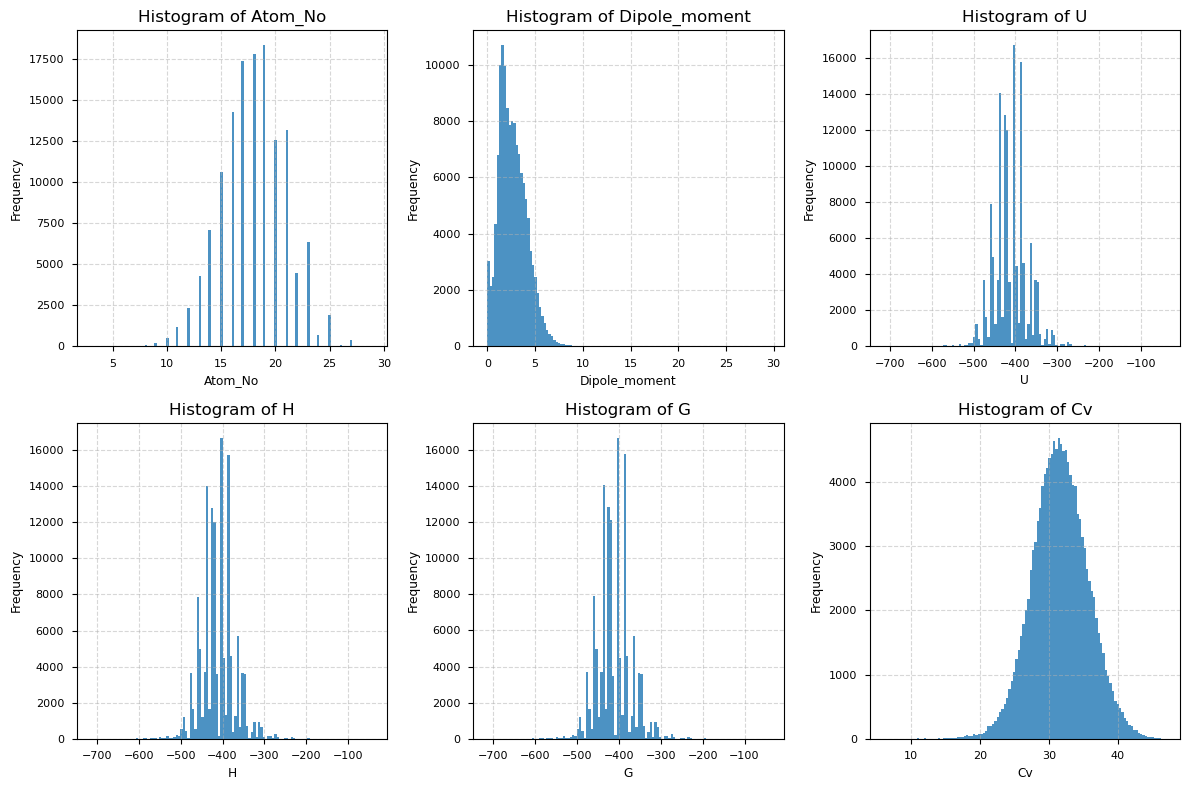

In [4]:
visualize_histogram(qm9_df, bins=120)

The energy columns have very similar values. A check ensues for their similarity. If the value differs less than 1% then only one column will be used as they are interchangeable.

In [5]:
similarity_check(qm9_df, ['U', 'H', 'G']) # less than 0.1% difference, so columns U, H, G interchangeable
qm9_df.drop(columns=['H', 'G'], inplace=True) # drop columns H and G
display(qm9_df.head())


Column Differences:
------------------------------
Comparing U vs H:
  Max absolute difference: 0.000945
  Mean absolute difference: 0.000944
  Max relative difference: 0.00%
  Mean relative difference: 0.00%
------------------------------
Comparing U vs G:
  Max absolute difference: 0.063876
  Mean absolute difference: 0.041884
  Max relative difference: 0.02%
  Mean relative difference: 0.01%
------------------------------
Comparing H vs G:
  Max absolute difference: 0.064821
  Mean absolute difference: 0.042828
  Max relative difference: 0.02%
  Mean relative difference: 0.01%
------------------------------


,SMILES,Atom_No,Dipole_moment,U,Cv
0,C,5,0.0000,-40.476062,6.469
1,N,4,1.6256,-56.523026,6.316
2,O,3,1.8511,-76.401867,6.002
3,C#C,4,0.0000,-77.305527,8.574
4,C#N,3,2.8937,-93.409370,6.278


U, H and G values were 99.9% simillar. Only Internal energy U is kept in the dataset.

Column Dipole_moment has 1413 outliers. Lower cuttof: -1.4823999999999995. Upper cutoff: 6.707199999999999
Column U has 2495 outliers. Lower cuttof: -514.205236. Upper cutoff: -310.740452
Column Cv has 1461 outliers. Lower cuttof: 20.940999999999995. Upper cutoff: 42.27700000000001


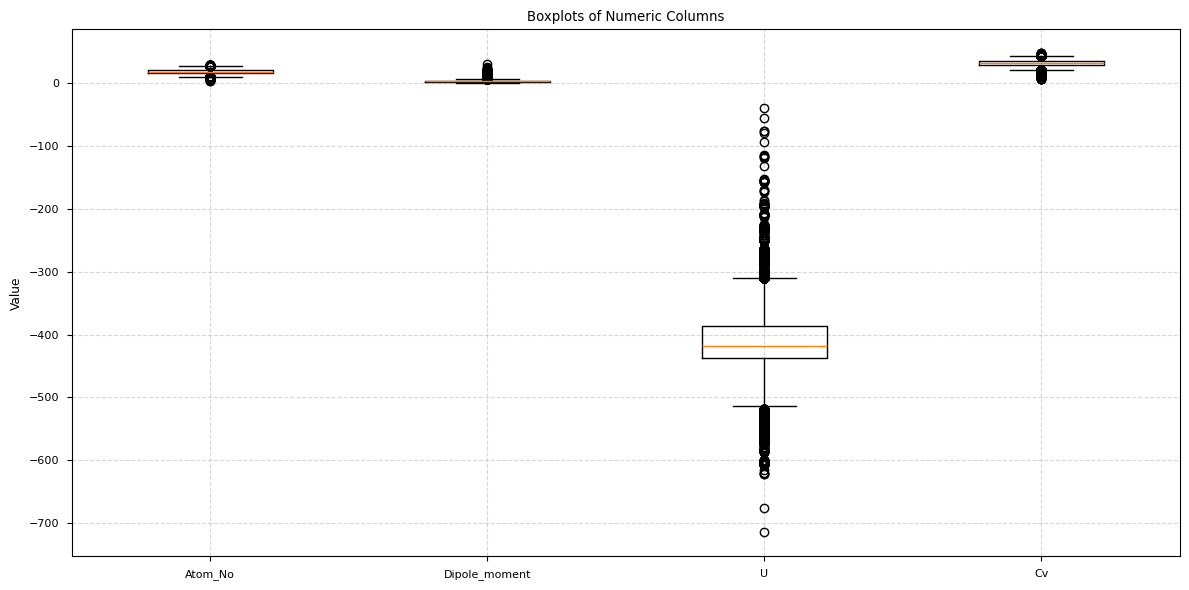

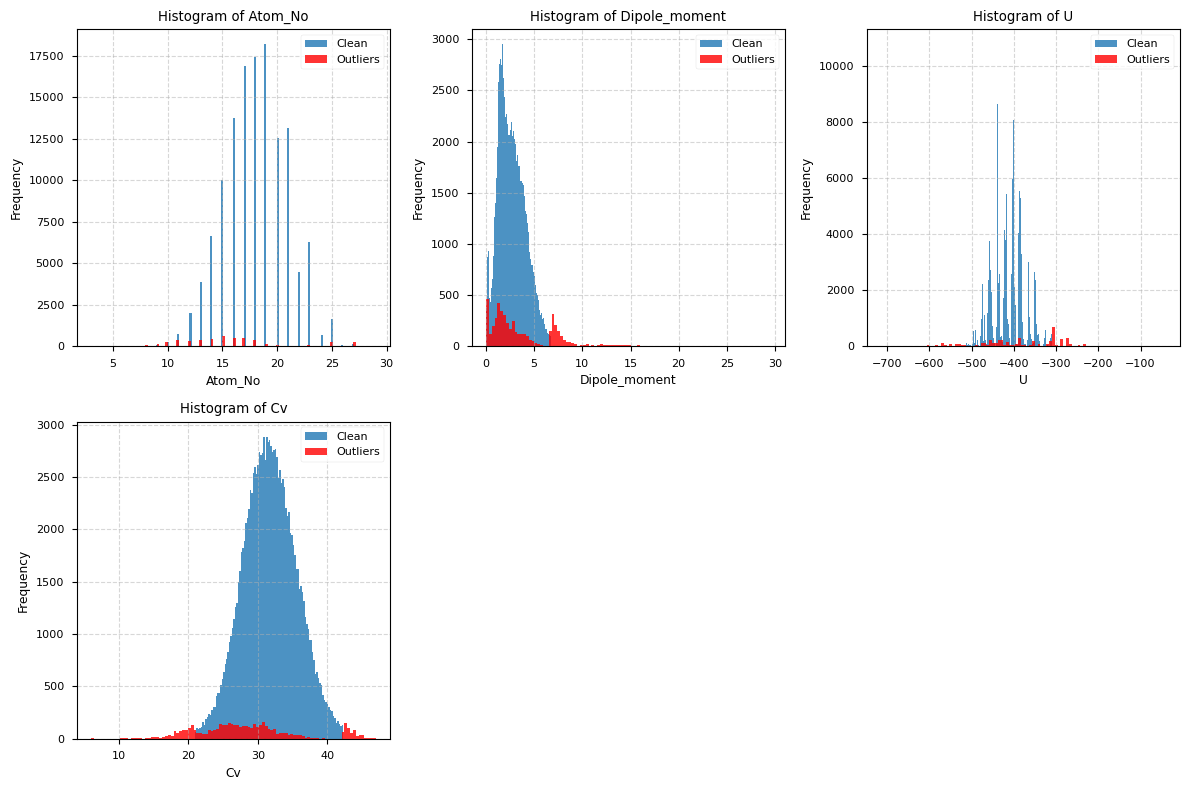

In [6]:
df_clean, df_outliers = outlier_detection(qm9_df)
visualize_outliers_boxplot(qm9_df)
visualize_outliers_histograms(df_clean, df_outliers)

Outliers are correct, however data in QM9 has valid property values. Thus, outliers are not dropped from the dataset in order to keep the information.

Minmax scaling is next

In [7]:
qm9_df, qm9_scalers = qm9_scaler(qm9_df, qm9_edit_dir)
display(qm9_df.head())
display(qm9_df.describe())

Dipole_moment column maximum value: 29.5564
Dipole_moment column minimum value: 0.0
U column maximum value: -40.476062
U column minimum value: -714.560153
Cv column maximum value: 46.969
Cv column minimum value: 6.002


,SMILES,Atom_No,Dipole_moment,U,Cv,Dipole_moment_scaled,U_scaled,Cv_scaled
0,C,5,0.0000,-40.476062,6.469,0.000000,1.000000,0.011399
1,N,4,1.6256,-56.523026,6.316,0.055000,0.976194,0.007665
2,O,3,1.8511,-76.401867,6.002,0.062629,0.946704,0.000000
3,C#C,4,0.0000,-77.305527,8.574,0.000000,0.945364,0.062782
4,C#N,3,2.8937,-93.409370,6.278,0.097904,0.921474,0.006737


,Atom_No,Dipole_moment,U,Cv,Dipole_moment_scaled,U_scaled,Cv_scaled
count,133885.000000,133885.000000,133885.000000,133885.000000,133885.000000,133885.000000,133885.000000
mean,17.983740,2.706037,-411.535513,31.600676,0.091555,0.449535,0.624861
std,2.954258,1.530394,40.060012,4.062471,0.051779,0.059429,0.099164
min,3.000000,0.000000,-714.560153,6.002000,0.000000,0.000000,0.000000
25%,16.000000,1.588700,-437.905942,28.942000,0.053751,0.410415,0.559963
50%,18.000000,2.500000,-417.857351,31.555000,0.084584,0.440157,0.623746
75%,20.000000,3.636100,-387.039746,34.276000,0.123022,0.485875,0.690165
max,29.000000,29.556400,-40.476062,46.969000,1.000000,1.000000,1.000000


### SMILES string to Graph conversion

In [ ]:

target_cols = ['Dipole_moment_scaled', 'U_scaled', 'Cv_scaled']
qm9_dataset_filename = 'qm9_dataset.pt'

test_smiles = 'CC'
test_targets = [1.0, 2.0, 3.0]
print(f'\nEthane test:\n{smiles_to_graph(test_smiles, test_targets)}')
# convert_smiles_to_graph(qm9_df, target_cols, qm9_edit_dir, qm9_dataset_filename) # Uncomment to run


Ethane test:
Data(x=[2, 14], edge_index=[2, 2], edge_attr=[2, 6], y=[1, 3])
